Enter the stock ticker symbol (e.g., AAPL for Apple): AMZN


[*********************100%***********************]  1 of 1 completed

Epoch 1/10


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0270
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 5.0056e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.4065e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 5.4450e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 4.5695e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 4.5088e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 4.8216e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5.7669e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 5.1285e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 4.5247e-04
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Root Mean Squared Error: 7.07


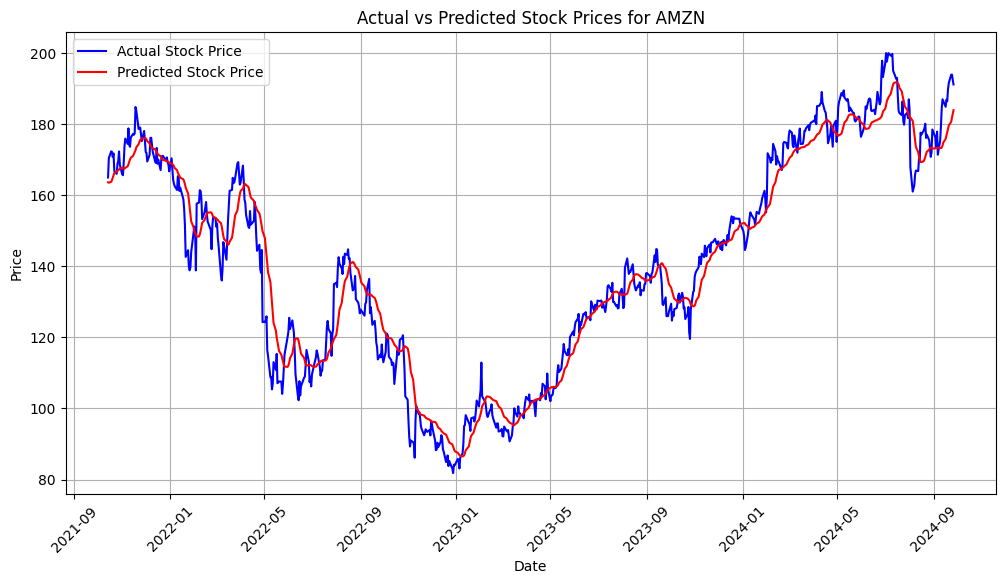

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted price for 2024-09-28: $184.74
Predicted price for 2024-09-29: $185.08
Predicted price for 2024-09-30: $185.15
Predicted price for 2024-10-01: $185.04
Predicted price for 2024-10-02: $184.81
Predicted price for 2024-10-03: $184.51
Predicted price for 2024-10-04: $184.17

Lowest predicted price for AMZN: $184.17 on 2024-10-04
Highest predicted price for AMZN: $185.15 on 2024-09-30


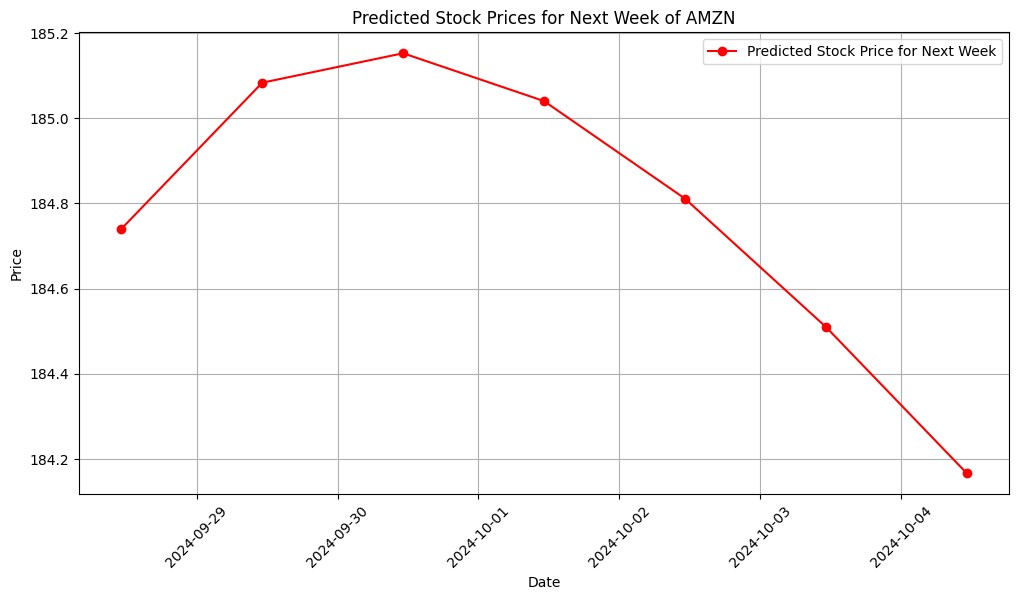

In [ ]:

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

# 1. Get user input for stock ticker
stock_name = input("Enter the stock ticker symbol (e.g., AAPL for Apple): ")

# 2. Load stock data until the current date
end_date = datetime.now().strftime('%Y-%m-%d')
stock_data = yf.download(stock_name, start='2010-01-01', end=end_date)

# 3. Preprocess the data: Use only the 'Close' prices for prediction
close_prices = stock_data['Close'].values
close_prices = close_prices.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create training data: 60 days of data for prediction of the price 7 days ahead
train_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_len]

# Create training sequences and labels (predicting 7 days ahead)
x_train, y_train = [], []
for i in range(60, len(train_data) - 7):
    x_train.append(train_data[i-60:i, 0])  # Use the past 60 days' data
    y_train.append(train_data[i+7, 0])     # Predict the price 7 days ahead

# Convert to NumPy arrays and reshape
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

from tensorflow.keras import Input

# 4. Build and train the LSTM model
model = Sequential()

# Use the Input() layer to specify the shape of the input data
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10)

# 5. Prepare test data for the last 60 days
test_data = scaled_data[train_len - 60:]  # Get the last 60 days for prediction
x_test = []
actual_prices = close_prices[train_len:]  # Actual prices for the last portion of the data

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# 6. Make predictions for the test data
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Inverse scaling for predictions

# 7. Calculate RMSE for the test data
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error: {rmse:.2f}")

# 8. Plot the actual vs predicted prices for the test data (last part)
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[train_len:], actual_prices, color='blue', label='Actual Stock Price')
plt.plot(stock_data.index[train_len:], predicted_prices, color='red', label='Predicted Stock Price')
plt.title(f'Actual vs Predicted Stock Prices for {stock_name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# 9. Prepare test data for predicting the next week
x_test = test_data[-60:].reshape(1, 60, 1)  # Reshape for LSTM input

# 10. Make predictions for the next week
predictions = []
for _ in range(7):  # Predict for the next 7 days
    pred = model.predict(x_test)
    predictions.append(pred[0, 0])  # Store the prediction

    # Update the x_test for the next prediction
    pred_reshaped = pred.reshape(1, 1, 1)  # Reshape predicted value
    x_test = np.append(x_test[:, 1:, :], pred_reshaped, axis=1)  # Shift the input data and append new prediction

# Inverse scale the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# 11. Prepare dates for the next 7 days starting from tomorrow
future_dates = [datetime.now() + timedelta(days=i) for i in range(1, 8)]

# 12. Print the predicted prices
for i in range(7):
    print(f"Predicted price for {future_dates[i].date()}: ${predictions[i]:.2f}")

# 13. Find the lowest and highest predicted prices for the next week
min_price = predictions.min()
max_price = predictions.max()
min_price_date = future_dates[np.argmin(predictions)]
max_price_date = future_dates[np.argmax(predictions)]

# 14. Print the results
print(f"\nLowest predicted price for {stock_name}: ${min_price:.2f} on {min_price_date.date()}")
print(f"Highest predicted price for {stock_name}: ${max_price:.2f} on {max_price_date.date()}")

# 15. Plot the predicted prices for the next week
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions, color='red', marker='o', label='Predicted Stock Price for Next Week')
plt.title(f'Predicted Stock Prices for Next Week of {stock_name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend()
plt.grid()
plt.show()
